<h2 id="anexog" style="background-color: #80B8D1 ; color: white; padding: 5px;font-size: 20px;">ANEXO G - ENTRENAMIENTO Y EVALUACIÓN - RED NEURONAL RECURRENTE PARTE I</h2>

### CARGA DE LIBRERIAS

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
import random
import pickle

from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import GroupShuffleSplit, RandomizedSearchCV, GroupKFold,cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, Input
from tensorflow.keras.models import Model
import time

### CARGA DE DATOS - LOCAL

In [ ]:
path = "../CMaps/"
train_doc = "train_FD004.txt"
test_doc = "test_FD004.txt"
test_target_doc="RUL_FD004.txt"

indices = ["unit_num", "cycle"]
settings = ["setting_1", "setting_2", "setting_3"]
sensor = ["s_{}".format(i+1) for i in range(0,21)]
col_nombres = indices + settings + sensor

#Leer los datos
train = pd.read_csv((path+train_doc), sep="\s+", header=None,
                 names=col_nombres)
test = pd.read_csv((path+test_doc), sep="\s+", header=None,
                 names=col_nombres)
y_test = pd.read_csv((path+test_target_doc), sep="\s+", header=None,
                 names=["RUL"])

### CARGA DE DATOS - COLAB

In [2]:
from google.colab import drive
drive.mount("/content/drive")

indices = ["unit_num", "cycle"]
settings = ["setting_1", "setting_2", "setting_3"]
sensor = ["s_{}".format(i+1) for i in range(0,21)]
col_nombres = indices + settings + sensor

#Leer los datos 

train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TFM/train_FD004.txt", sep="\s+", header=None, names=col_nombres)
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TFM/test_FD004.txt", sep="\s+", header=None, names=col_nombres)
y_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TFM/RUL_FD004.txt", sep="\s+", header=None, names=["RUL"])

Mounted at /content/drive


### FUNCIONES AUXILIARES

In [3]:
def RUL_add(dataframe,clipped=False,early=None):
    if "unit_num" in dataframe.columns and "cycle" in dataframe.columns:

        df_rul=dataframe.groupby("unit_num")["cycle"].max().reset_index()
        df_rul.columns=["unit_num","max"]
        dataframe = pd.merge(dataframe, df_rul, on="unit_num")
        dataframe["RUL"]=dataframe["max"]-dataframe["cycle"]
        dataframe=dataframe.drop(labels="max",axis=1)

        if clipped:
             dataframe["RUL"]=dataframe["RUL"].clip(upper=early)

        return dataframe
    else:
        print("El dataframe debe contener las columnas unit_num y cycle")

### PROCESAMIENTO DE DATOS

In [4]:
train["setting_1"]=train["setting_1"].round(decimals=1)
train["setting_2"]=train["setting_2"].round(decimals=2)

test["setting_1"]=test["setting_1"].round(decimals=1)
test["setting_2"]=test["setting_2"].round(decimals=2)

In [5]:
seed=42

#Train
X_train=RUL_add(train,True,125)
groups=X_train.unit_num

y_train=X_train[["unit_num","RUL"]] #Se adiciona unit_num para implementar la generación de secuencias por unidad (motor)
X_train=X_train.drop(labels=["RUL","cycle"],axis=1) #Se mantiene "unit_num"  para implementar la generación de secuencias por unidad (motor)

#Test
X_test=test.drop(labels=["cycle"],axis=1)#no saco "unit_num"  para implementar la generación de secuencias por unidad (motor)

#Se crea variable condición operativa
X_train["condición_op"] = X_train["setting_1"].astype(str) + "_" + \
                        X_train["setting_2"].astype(str) + "_" + \
                        X_train["setting_3"].astype(str)

X_test["condición_op"] = X_test["setting_1"].astype(str) + "_" + \
                        X_test["setting_2"].astype(str) + "_" + \
                        X_test["setting_3"].astype(str)


#Escalado por condición operativa
for cond in X_train["condición_op"].unique():
    filtro=X_train[X_train["condición_op"]==cond]
    filtro_test=X_test[X_test["condición_op"]==cond]
    scaler = MinMaxScaler()
    scaler.fit(filtro[sensor])
    X_train.loc[X_train["condición_op"]==cond, sensor]=scaler.transform(filtro[sensor])
    X_test.loc[X_test["condición_op"]==cond, sensor]=scaler.transform(filtro_test[sensor])


#Se eliminan las 3 variables setting y se crean variables dummies para la variable condición operativa
X_train=X_train.drop(labels=settings,axis=1)
X_test=X_test.drop(labels=settings,axis=1)

X_train=pd.get_dummies(data=X_train,columns=["condición_op"])
X_test=pd.get_dummies(data=X_test,columns=["condición_op"])

#Eliminación de variables no seleccionadas durante el FE.
sensores_a_eliminar = ["s_1", "s_5", "s_18", "s_19","s_10"]
X_train=X_train.drop(labels=sensores_a_eliminar,axis=1)
X_test=X_test.drop(labels=sensores_a_eliminar,axis=1)
sensor = list(set(sensor) - set(sensores_a_eliminar))


print(f"Tamaño X_train = {X_train.shape} y Tamaño y_train = {y_train.shape}\nTamaño X_test {X_test.shape} y Tamaño y_test {y_test.shape}")

Tamaño X_train = (61249, 23) y Tamaño y_train = (61249, 2)
Tamaño X_test (41214, 23) y Tamaño y_test (248, 1)


**NOTA**: al procesar los datos, no se quita la columna *unit_num* puesto que será necesaria para la implementación de las secuencias (las mismas se deberán aplicar por motor y no a todo el dataframe)

### INTRODUCCIÓN

El aprendizaje profundo (Deep Learning) ha demostrado tener un rendimiento superior en muchos campos. En particular, ha demostrado amplias mejorías en ámbitos vinculados con datos de series temporales. El Mantenimiento Predictivo es un ejemplo donde contamos con datos temporales para monitorear el estado de un equipo con el objetivo de encontrar patrones que permitan predecir fallos, por lo que también puede beneficiarse de ciertos algoritmos de aprendizaje profundo. Entre los métodos de aprendizaje profundo, las redes LSTM (Long Short Term Memory) son especialmente atractivas para el ámbito del mantenimiento predictivo debido a que son muy efectivas para aprender de secuencias. Mejoran la detección de patrones de fallos al permitir una retrospección a largo plazo en el tiempo.    

Los modelos tradicionales, como los hasta ahora trabajados, se fundamentan en la ingeniería de variables, que consiste en la construcción manual de variables temporales mediante análisis o experiencia en el sector. Lo anterior conduce a que estos modelos sean difíciles de reutilizar, ya que la ingeniería de variables es específica para el escenario del problema y los datos disponibles, que varían de un negocio a otro. Por tanto, la ventaja más atractiva de aplicar el aprendizaje profundo es el hecho de que estas redes pueden extraer automáticamente las características adecuadas de los datos, eliminando la necesidad de la ingeniería manual.  

Las redes LSTM son capaces de tomar una secuencia de una ventana de tiempo determinada como entrada y deslizar esta ventana a lo largo de la serie temporal. Este enfoque nos permite aprovechar al máximo la dependencia temporal inherente en los datos, sin necesidad de intervención manual. Por ello, un parámetro importante que se deberá considerar es la longitud de secuencia, es decir el tamaño de la ventana.



### CREACIÓN DE SECUENCIAS

La siguiente imagen ilustra el proceso de creación de secuencias con un tamaño de ventana de 4. Se inicia seleccionando este tamaño de ventana y luego se procede a recorrer el conjunto de datos. La primera secuencia se forma tomando los primeros 4 valores de todas las variables independientes, generando así una matriz de tamaño (tamaño de la ventana, cantidad de variables). Esta matriz se convierte en un registro de nuestro conjunto X y se asocia con un valor de RUL (y), que en este ejemplo corresponde al tiempo 4. La siguiente secuencia será entonces una matriz con las observaciones del tiempo 1 al 5 para todas las variables independientes, y estará asociado a una variable objetivo correspondiente al tiempo 5. De esta forma se recorre todo el conjunto de datos.

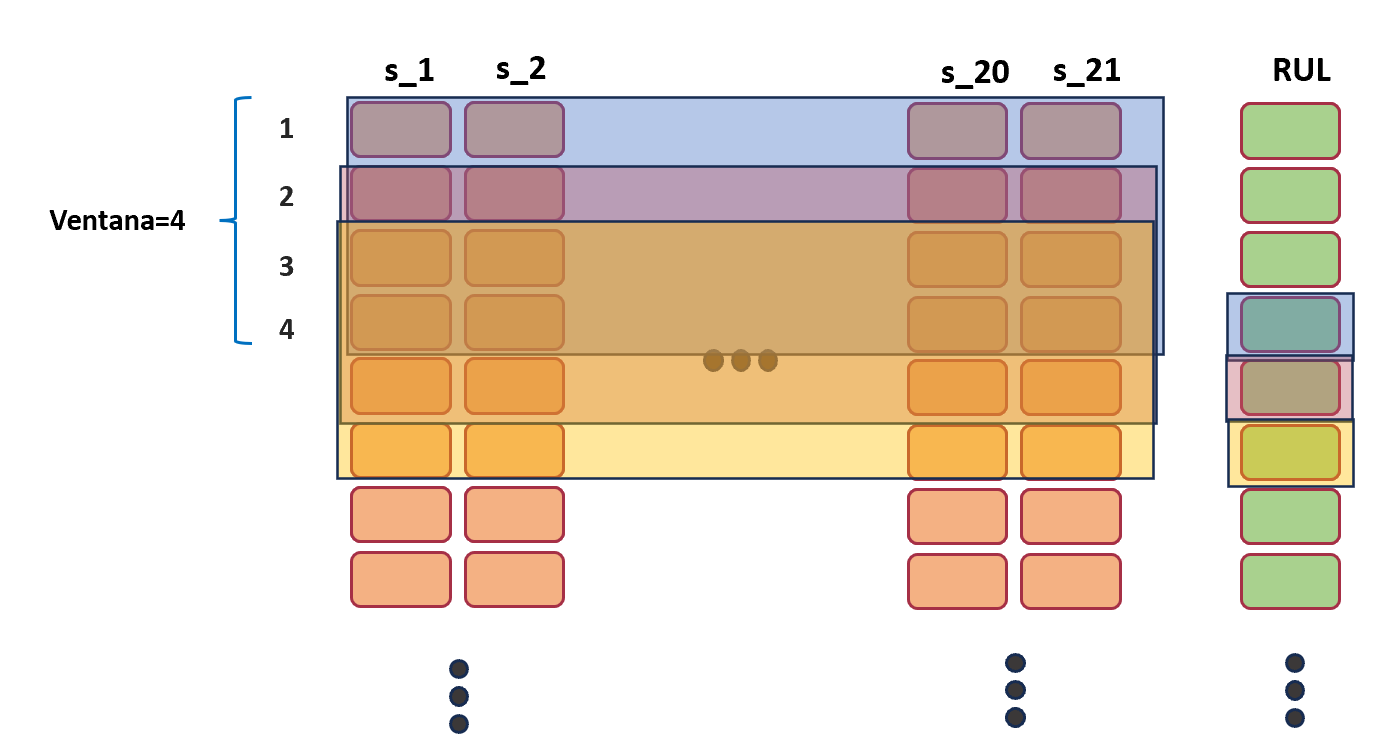

Ahora bien, es importante resaltar que lo anterior se debe realizar por unidad de motor. Las secuencias solo deberían contener datos de un único "unit_num" para evitar mezclar registros donde la falla es inminente con registros del siguiente motor que aún funciona correctamente.

En base a lo mencionado anteriormente, se definió una función para crear secuencias a partir del dataframe original y una ventana especificada. A su vez la función toma como variable de entradas las columnas a las que debe ser aplicada. En estas se deberá excluir la columna de identificación "unit_num" para no incluirla en las secuencias. Sin embargo, si será utilizada para realizar la creación de secuencias para cada unidad y no a todo el dataset completo.

In [6]:
#Función individual: a aplicar para cada "unit_num"
def Crear_Secuencias_X(df,ventana,columnas):
    data=df[columnas].copy()
    observaciones=data.shape[0]

    desde=range(0,observaciones-(ventana-1))
    hasta=range(ventana,observaciones+1)

    for i,j in zip(desde,hasta):
        yield data.iloc[i:j,].values

def Crear_Secuencias_y(df,ventana,columnas):
    data=df[columnas].copy()
    observaciones=data.shape[0]
    return data.iloc[ventana-1:observaciones,].values

#Función para aplicar a todo el dataframe
def Crear_Secuencias_X_total(df,ventana,columnas):
    array=(list(Crear_Secuencias_X(df[df["unit_num"]==i],ventana,columnas)) for i in df["unit_num"].unique())
    array=np.concatenate(list(array)).astype(np.float32)
    return array

def Crear_Secuencias_y_total(df,ventana,columnas):
    array=[Crear_Secuencias_y(df[df["unit_num"]==i],ventana,columnas) for i in df["unit_num"].unique()]
    array=np.concatenate(list(array)).astype(np.float32)
    return array

En el conjunto de pruebas, solo tenemos acceso al valor de la RUL asociado al último registro de cada motor. Por lo tanto, se creó una función específica para extraer la última ventana temporal de datos para cada motor.

Sin embargo, dado que la cantidad de registros por motor puede variar en el conjunto de pruebas y algunos motores incluso pueden tener un número reducido de muestras, se debe tener en cuenta la posibilidad de que el tamaño de ventana sea superior a la cantidad de registros. Para contemplar esta situación, se implementó un proceso de relleno (padding) que tiene como objetivo completar los datos hasta alcanzar la longitud deseada de la ventana. Sin embargo, es importante resaltar que a la hora de crear un modelo, se deberán hacerlo de forma ta que ignore dichos valores.

In [7]:
def Crear_Secuencias_X_test(df,ventana,columnas,padding_num):
    data=df.copy()
    observaciones=data.shape[0]

    if observaciones < ventana:
        dif=ventana-observaciones
        array = np.full((ventana, len(columnas)), padding_num)
        array = np.vstack((array[:dif, :], data[col_x].values))
    else:
        array=data[columnas].values

    yield array[array.shape[0]-ventana:array.shape[0],:]

### CONSTRUCCIÓN DEL MODELO

En el proceso de desarrollo de un modelo LSTM se relizará una exploración de diferentes arquitecturas de redes neuronales recurrentes. El objetivo principal es comprender cómo se comportan estos modelos en relación con nuestro conjunto de datos. Se realizarán pruebas utilizando distintas configuraciones, comenzando desde las más simples hasta las más complejas (incrementando la profundidad de las redes).

- *MODELO A*: Una capa LSTM, y una capa densa de salida.
- *MODELO B*: Dos capas LSTM y una capa densa de salida.
- *MODELO C*: Tres capas LSTM y una capa densa de salida.
- *MODELO D*: Dos capas LSTM y dos capas densas.
- *MODELO E*: Tres capas LSTM y dos capas densas.

Es importante destacar que, debido a que el objetivo es predecir la RUL, la última capa de todos los modelos debe ser una capa densa con una sola neurona. La función de activación puede ser ReLU o lineal, ya que se trata de un problema de regresión.

Para un análisis más exhaustivo de las distintas arquitecturas propuestas, se entrenan los cinco modelos utilizando dos tamaños de ventana diferentes: uno pequeño (5) y otro grande (30), con el propósito de extraer conclusiones más sólidas.  Cabe resaltar que esta primera exploración tiene por objetivo determinar una arquitectura adecuada. La selección del tamaño de ventana, así como el ajuste de los hiperparámetros se realizará en una fase posterior.

#### ENTRENAMIENTO DE LOS MODELOS PROPUESTOS (VENTANA=5)
Previo a entrenar el modelo es preciso:

- Dividir los datos en entrenamiento y validación manteniendo la homogeneidad según número de motor. Como hasta ahora, esto se realizó aplicando GroupShuffleSplit.
- Definir tamaño de ventana (5 para este caso de análisis).
- Crear las secuencias aplicando las funciones creadas para tal fin.

In [ ]:
#Semilla
seed=42
tf.keras.utils.set_random_seed(seed)
tf.config.experimental.enable_op_determinism()

In [ ]:
#Se aplica group shuffle split para separar en train/validation set

gss = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=seed)
for train_indices, val_idices in gss.split(X_train,y_train,groups=groups):
    X_train_split, X_val_split = X_train.iloc[train_indices],X_train.iloc[val_idices]
    y_train_split, y_val_split =y_train.iloc[train_indices],y_train.iloc[val_idices]


#Se define el tamaño de ventana y el batch
ventana=5
batch=64

#Se crean las secuencias para el conjunto de entrenamiento y validación

col_x = list(set(X_train.columns) - set(["unit_num"])) #features
col_y = ["RUL"] #target

X_train_array = Crear_Secuencias_X_total(X_train_split, ventana=ventana, columnas=col_x)
X_val_array = Crear_Secuencias_X_total(X_val_split, ventana=ventana, columnas=col_x)
y_train_array = Crear_Secuencias_y_total(y_train_split, ventana=ventana, columnas=col_y)
y_val_array = Crear_Secuencias_y_total(y_val_split, ventana=ventana, columnas=col_y)

print(X_train_array.shape)

(51592, 5, 22)


A continuación, se detalla el proceso de construcción y entrenamiento del Modelo A.

**DEFINICIÓN DEL MODELO**

- **Capa inputs**: el modelo toma una secuencia de datos de entrada con la forma (ventana, num_features), donde ventana es la longitud de la secuencia de tiempo y num_features es el número de variables.

- **Capa mask**: se agrega una capa Masking al modelo con el propósito de descartar valores específicos (en este caso, mask_value=-99). Esta capa resultará útil cuando tratemos con datos de prueba que han sido ajustados mediante la técnica de relleno (padding) para que coincidan con la longitud de la ventana de tiempo. Al añadir relleno, se completan las secuencias de datos, pero el modelo debe ignorar estos datos de relleno. La capa Masking asegura que los valores de relleno sean excluidos del procesamiento del modelo, permitiendo que se concentre en los datos relevantes y evitando que los valores de relleno influyan en las predicciones.

- **Capa lstm_1**: se adiciona una capa LSTM (Long Short-Term Memory) con 256 neuronas, que se aplica a la secuencia de entrada. Si bien se definió un número de neuronas, una vez definida la arquitectura final se realizará el ajuste de dicho hiperparámetro.

- **Capa output**: finalmente, se declara una capa densa con una única neurona que produce la salida del modelo.

**COMPILACIÓN DEL MODELO**  

Cuando se construye y entrena un modelo de red neuronal, es necesario configurar varios aspectos antes de comenzar el proceso de aprendizaje. Uno de los pasos es la compilación del modelo, donde se especifican dos elementos clave: la función de pérdida y el optimizador.
- La **función de pérdida** es la métrica que cuantifica la discrepancia entre las predicciones del modelo y los valores reales del conjunto de datos de entrenamiento. En este caso, se utiliza la función de pérdida de error cuadrático medio. La función de pérdida se calcula en cada iteración y para ello se puede calcular utilizando todos los datos (batch=número de observaciones) o para un tamaño de batch menor. En el primer caso la exigencia computacional es muy grande y por tanto se suelen utilizar batchs más pequeños. En esta instancia se definió en 64, sin embargo, al igual que otros hiperparámetros, éste será ajustado luego de definir una arquitectura general.

- El **optimizador** es el algoritmo que ajusta los pesos y los sesgos durante el proceso de entrenamiento. En este caso, se utiliza el optimizador Adam que es un algoritmo de optimización popular en el aprendizaje profundo. Adam ajusta los parámetros del modelo en función del gradiente de la función de pérdida definida, lo que permite que el modelo aprenda de manera eficiente y rápida.

**ENTRENAMIENTO DEL MODELO**  

Una vez compilado el modelo se está en condiciones de proceder al entrenamiento. Antes de ello, se definió un callback de **Early Stopping** que monitorea la pérdida en el conjunto de validación (val_loss) y detiene el entrenamiento si la pérdida en el conjunto de validación deja de mejorar durante un cierto número de épocas (20 en este caso). A continuación, se entrena el modelo utilizando las secuencias de entrenamiento (X_train_array y y_train_array) y se utilizan las secuencias de validación (X_val_array y y_val_array) para monitorear el rendimiento durante el entrenamiento.


In [ ]:
#MODELO A

num_features = len(col_x)
inputs = Input(shape=(ventana, num_features))
mask = Masking(mask_value=-99.)(inputs)
lstm_1 = LSTM(256,return_sequences=False)(mask)
output = Dense(1)(lstm_1)

#Crear el modelo
model_A = Model(inputs=inputs, outputs=output)

model_A.summary()

model_A.compile(loss="mean_squared_error", optimizer="adam")


es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=20)


st=time.time()
history_A = model_A.fit(X_train_array,y_train_array,
                    validation_data=(X_val_array,y_val_array),
                    epochs=50,
                    batch_size=batch,
                    callbacks=[es_callback])

print(f"Total time: {time.time()-st}")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 22)]           0         
                                                                 
 masking_1 (Masking)         (None, 5, 22)             0         
                                                                 
 lstm_2 (LSTM)               (None, 256)               285696    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 285,953
Trainable params: 285,953
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
807/807 [==============================] - 21s 24ms/step - loss: 2472.1321 - val_loss: 1702.3153
Epoch 2/50
807/807 [==============================] - 18s 22ms/step - loss: 1

De manera similar a cómo se llevó a cabo con el Modelo A, se procede a construir los modelos subsiguientes, implementando modificaciones en la arquitectura.

In [ ]:
#MODELO B

num_features = len(col_x)
inputs = Input(shape=(ventana, num_features))
mask = Masking(mask_value=-99.)(inputs)
lstm_1 = LSTM(256,return_sequences=True)(mask)
lstm_2=LSTM(128)(lstm_1)
output = Dense(1)(lstm_2)

#Crear el modelo
model_B = Model(inputs=inputs, outputs=output)

model_B.summary()

model_B.compile(loss="mean_squared_error", optimizer="adam")


es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=20)


st=time.time()
history_B = model_B.fit(X_train_array,y_train_array,
                    validation_data=(X_val_array,y_val_array),
                    epochs=50,
                    batch_size=batch,
                    callbacks=[es_callback])

print(f"Total time: {time.time()-st}")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 22)]           0         
                                                                 
 masking (Masking)           (None, 5, 22)             0         
                                                                 
 lstm (LSTM)                 (None, 5, 256)            285696    
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 482,945
Trainable params: 482,945
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
807/807 [==============================] - 3

In [ ]:
#MODELO C

num_features = len(col_x)
inputs = Input(shape=(ventana, num_features))
mask = Masking(mask_value=-99.)(inputs)
lstm_1 = LSTM(256,return_sequences=True)(mask)
lstm_2=LSTM(128,return_sequences=True)(lstm_1)
lstm_3=LSTM(64)(lstm_2)
output = Dense(1)(lstm_3)

#Crear el modelo
model_C = Model(inputs=inputs, outputs=output)

model_C.summary()

model_C.compile(loss="mean_squared_error", optimizer="adam")


es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=20)


st=time.time()
history_C = model_C.fit(X_train_array,y_train_array,
                    validation_data=(X_val_array,y_val_array),
                    epochs=50,
                    batch_size=batch,
                    callbacks=[es_callback])

print(f"Total time: {time.time()-st}")

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5, 22)]           0         
                                                                 
 masking_2 (Masking)         (None, 5, 22)             0         
                                                                 
 lstm_3 (LSTM)               (None, 5, 256)            285696    
                                                                 
 lstm_4 (LSTM)               (None, 5, 128)            197120    
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 532,289
Trainable params: 532,289
Non-trainab

In [ ]:
#MODELO D

num_features = len(col_x)
inputs = Input(shape=(ventana, num_features))
mask = Masking(mask_value=-99.)(inputs)
lstm_1 = LSTM(256,return_sequences=True)(mask)
lstm_2=LSTM(128,return_sequences=False)(lstm_1)
Dense_1=Dense(64)(lstm_2)
output = Dense(1)(Dense_1)

#Crear el modelo
model_D = Model(inputs=inputs, outputs=output)

model_D.summary()

model_D.compile(loss="mean_squared_error", optimizer="adam")


es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=20)


st=time.time()
history_D = model_D.fit(X_train_array,y_train_array,
                    validation_data=(X_val_array,y_val_array),
                    epochs=50,
                    batch_size=batch,
                    callbacks=[es_callback])

print(f"Total time: {time.time()-st}")

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 5, 22)]           0         
                                                                 
 masking_4 (Masking)         (None, 5, 22)             0         
                                                                 
 lstm_8 (LSTM)               (None, 5, 256)            285696    
                                                                 
 lstm_9 (LSTM)               (None, 128)               197120    
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 491,137
Trainable params: 491,137
Non-trainab

In [ ]:
#MODELO E

num_features = len(col_x)
inputs = Input(shape=(ventana, num_features))
mask = Masking(mask_value=-99.)(inputs)
lstm_1 = LSTM(256,return_sequences=True)(mask)
lstm_2=LSTM(128,return_sequences=True)(lstm_1)
lstm_3=LSTM(64,return_sequences=False)(lstm_2)
Dense_1=Dense(64)(lstm_3)
output = Dense(1)(Dense_1)

#Crear el modelo
model_E = Model(inputs=inputs, outputs=output)

model_E.summary()

model_E.compile(loss="mean_squared_error", optimizer="adam")


es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=20)


st=time.time()
history_E = model_E.fit(X_train_array,y_train_array,
                    validation_data=(X_val_array,y_val_array),
                    epochs=50,
                    batch_size=batch,
                    callbacks=[es_callback])

print(f"Total time: {time.time()-st}")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 22)]           0         
                                                                 
 masking (Masking)           (None, 5, 22)             0         
                                                                 
 lstm (LSTM)                 (None, 5, 256)            285696    
                                                                 
 lstm_1 (LSTM)               (None, 5, 128)            197120    
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65    

#### ENTRENAMIENTO DE LOS MODELOS PROPUESTOS (VENTANA=30)

Nuevamente, previo a entrenar el modelo se realizaron los siguientes pasos:

- Dividir los datos en entrenamiento y validación manteniendo la homogeneidad según número de motor.
- Definir tamaño de ventana (30 para este caso de análisis).
- Crear las secuencias aplicando las funciones creadas para tal fin.

In [ ]:
#Semilla
seed=42
tf.keras.utils.set_random_seed(seed)
tf.config.experimental.enable_op_determinism()

In [ ]:
#Se aplica group shuffle split para separar en train/validation set

gss = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=seed)
for train_indices, val_idices in gss.split(X_train,y_train,groups=groups):
    X_train_split, X_val_split = X_train.iloc[train_indices],X_train.iloc[val_idices]
    y_train_split, y_val_split =y_train.iloc[train_indices],y_train.iloc[val_idices]

#Se define el tamaño de ventana y el batch
ventana=30
batch=64

#Se crean las secuencias para el conjunto de entrenamiento y validación
col_x = list(set(X_train.columns) - set(["unit_num"]))
col_y = ["RUL"]

X_train_array = Crear_Secuencias_X_total(X_train_split, ventana=ventana, columnas=col_x)
X_val_array = Crear_Secuencias_X_total(X_val_split, ventana=ventana, columnas=col_x)
y_train_array = Crear_Secuencias_y_total(y_train_split, ventana=ventana, columnas=col_y)
y_val_array = Crear_Secuencias_y_total(y_val_split, ventana=ventana, columnas=col_y)

print(X_train_array.shape)

(46317, 30, 22)


In [ ]:
#MODELO 2A

num_features = len(col_x)
inputs = Input(shape=(ventana, num_features))
mask = Masking(mask_value=-99.)(inputs)
lstm_1 = LSTM(256,return_sequences=False)(mask)
output = Dense(1)(lstm_1)

#Crear el modelo
model_2A = Model(inputs=inputs, outputs=output)

model_2A.summary()

model_2A.compile(loss="mean_squared_error", optimizer="adam")


es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=20)


st=time.time()
history_2A = model_2A.fit(X_train_array,y_train_array,
                    validation_data=(X_val_array,y_val_array),
                    epochs=50,
                    batch_size=batch,
                    callbacks=[es_callback])

print(f"Total time: {time.time()-st}")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 22)]          0         
                                                                 
 masking (Masking)           (None, 30, 22)            0         
                                                                 
 lstm (LSTM)                 (None, 256)               285696    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 285,953
Trainable params: 285,953
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
724/724 [==============================] - 77s 103ms/step - loss: 2560.9277 - val_loss: 1751.4520
Epoch 2/50
724/724 [==============================] - 81s 111ms/step - loss: 1

In [ ]:
#MODELO 2B

num_features = len(col_x)
inputs = Input(shape=(ventana, num_features))
mask = Masking(mask_value=-99.)(inputs)
lstm_1 = LSTM(256,return_sequences=True)(mask)
lstm_2=LSTM(128)(lstm_1)
output = Dense(1)(lstm_2)

#Crear el modelo
model_2B = Model(inputs=inputs, outputs=output)

model_2B.summary()

model_2B.compile(loss="mean_squared_error", optimizer="adam")


es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=20)


st=time.time()
history_2B = model_2B.fit(X_train_array,y_train_array,
                    validation_data=(X_val_array,y_val_array),
                    epochs=50,
                    batch_size=batch,
                    callbacks=[es_callback])

print(f"Total time: {time.time()-st}")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30, 22)]          0         
                                                                 
 masking_1 (Masking)         (None, 30, 22)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 256)           285696    
                                                                 
 lstm_2 (LSTM)               (None, 128)               197120    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 482,945
Trainable params: 482,945
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
724/724 [==============================] -

In [ ]:
#MODELO 2C

num_features = len(col_x)
inputs = Input(shape=(ventana, num_features))
mask = Masking(mask_value=-99.)(inputs)
lstm_1 = LSTM(256,return_sequences=True)(mask)
lstm_2=LSTM(128,return_sequences=True)(lstm_1)
lstm_3=LSTM(64)(lstm_2)
output = Dense(1)(lstm_3)

#Crear el modelo
model_2C = Model(inputs=inputs, outputs=output)

model_2C.summary()

model_2C.compile(loss="mean_squared_error", optimizer="adam")


es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=20)


st=time.time()
history_2C = model_2C.fit(X_train_array,y_train_array,
                    validation_data=(X_val_array,y_val_array),
                    epochs=50,
                    batch_size=batch,
                    callbacks=[es_callback])

print(f"Total time: {time.time()-st}")

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30, 22)]          0         
                                                                 
 masking_2 (Masking)         (None, 30, 22)            0         
                                                                 
 lstm_3 (LSTM)               (None, 30, 256)           285696    
                                                                 
 lstm_4 (LSTM)               (None, 30, 128)           197120    
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 532,289
Trainable params: 532,289
Non-trainab

In [ ]:
#MODELO 2D

num_features = len(col_x)
inputs = Input(shape=(ventana, num_features))
mask = Masking(mask_value=-99.)(inputs)
lstm_1 = LSTM(256,return_sequences=True)(mask)
lstm_2=LSTM(128,return_sequences=False)(lstm_1)
Dense_1=Dense(64)(lstm_2)
output = Dense(1)(Dense_1)

#Crear el modelo
model_2D = Model(inputs=inputs, outputs=output)

model_2D.summary()

model_2D.compile(loss="mean_squared_error", optimizer="adam")


es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=20)


st=time.time()
history_2D = model_2D.fit(X_train_array,y_train_array,
                    validation_data=(X_val_array,y_val_array),
                    epochs=50,
                    batch_size=batch,
                    callbacks=[es_callback])

print(f"Total time: {time.time()-st}")

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 30, 22)]          0         
                                                                 
 masking_3 (Masking)         (None, 30, 22)            0         
                                                                 
 lstm_6 (LSTM)               (None, 30, 256)           285696    
                                                                 
 lstm_7 (LSTM)               (None, 128)               197120    
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 491,137
Trainable params: 491,137
Non-trainab

In [ ]:
#MODELO 2E

num_features = len(col_x)
inputs = Input(shape=(ventana, num_features))
mask = Masking(mask_value=-99.)(inputs)
lstm_1 = LSTM(256,return_sequences=True)(mask)
lstm_2=LSTM(128,return_sequences=True)(lstm_1)
lstm_3=LSTM(64,return_sequences=False)(lstm_2)
Dense_1=Dense(64)(lstm_3)
output = Dense(1)(Dense_1)

#Crear el modelo
model_2E = Model(inputs=inputs, outputs=output)

model_2E.summary()

model_2E.compile(loss="mean_squared_error", optimizer="adam")


es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=20)


st=time.time()
history_2E = model_2E.fit(X_train_array,y_train_array,
                    validation_data=(X_val_array,y_val_array),
                    epochs=50,
                    batch_size=batch,
                    callbacks=[es_callback])

print(f"Total time: {time.time()-st}")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30, 22)]          0         
                                                                 
 masking_1 (Masking)         (None, 30, 22)            0         
                                                                 
 lstm_3 (LSTM)               (None, 30, 256)           285696    
                                                                 
 lstm_4 (LSTM)               (None, 30, 128)           197120    
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65  

#### ANÁLISIS DE RESULTADOS

Una vez completado el entrenamiento de los cinco modelos para ambos tamaños de ventana, se procede a realizar un análisis de los resultados obtenidos.
A continuación, se presentan gráficas que muestran la evolución de la función de pérdida tanto en el conjunto de entrenamiento como en el de validación, primero utilizando una ventana de tamaño 5 para los cinco modelos (gráfico 1) y luego repitiendo el proceso con una ventana de tamaño 30 (gráfico 2). Finalmente, se incluye una tercera gráfica que permite comparar directamente los modelos, uno a uno, entre los dos tamaños de ventana (gráfico 3).

**Gráfico 1: Evolución de Pérdida (entrenamiento y validación) (ventana=5)**

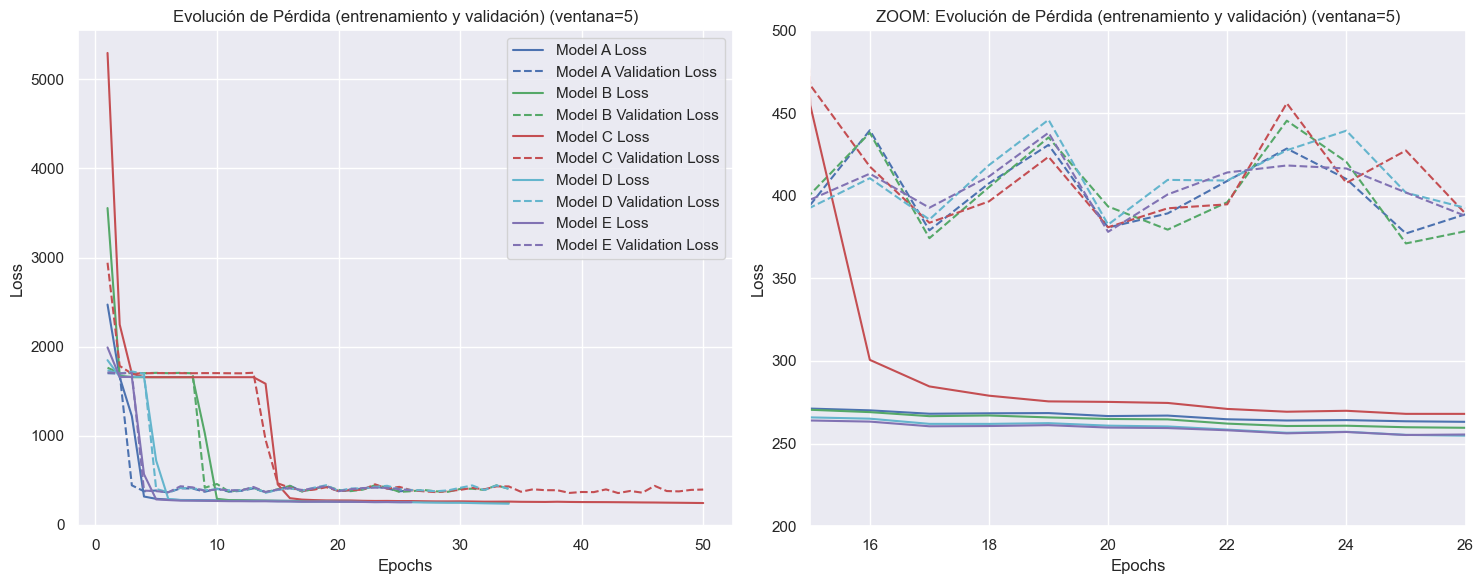

In [ ]:
models = ["A", "B", "C", "D", "E"]
colors = ["b", "g", "r", "c", "m"]

#Gráfico de loss y val loss vs épocas. 
plt.figure(figsize=(15, 6))

for i, model in enumerate(models):
    loss = locals()[f"history_{model}"].history["loss"]
    val_loss = locals()[f"history_{model}"].history["val_loss"]
    color = colors[i]

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(loss) + 1), loss, color=color, label=f"Model {model} Loss")
    plt.plot(range(1, len(val_loss) + 1), val_loss, linestyle="dashed", color=color, label=f"Model {model} Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Evolución de Pérdida (entrenamiento y validación) (ventana=5)")
    plt.legend()
    plt.grid(True)

    #Idem con zoom 
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(loss) + 1), loss, color=color, label=f"Model {model} Loss")
    plt.plot(range(1, len(val_loss) + 1), val_loss, linestyle="dashed", color=color, label=f"Model {model} Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("ZOOM: Evolución de Pérdida (entrenamiento y validación) (ventana=5)")
    plt.grid(True)
    plt.xlim(15, len(loss))
    plt.ylim(200, 500)


plt.tight_layout()
plt.show()


Al comparar los cinco modelos utilizando una ventana pequeña (tamaño 5), no se observa una mejora significativa de uno respecto a otro. Los resultados mostraron un comportamiento bastante similar y no hubo un modelo que se destacara claramente sobre los demás en cuanto a la pérdida en el conjunto de validación. Solamente se observan diferencias en cuanto al tiempo de convergencia, siendo los modelos B y C los que más tardaron en converger. Sin embargo, en cuanto al valor de pérdida alcanzado en el conjunto de validación, ninguno supera de manera evidente a los otros.

**Gráfico 2: Evolución de Pérdida (entrenamiento y validación) (ventana=30)**

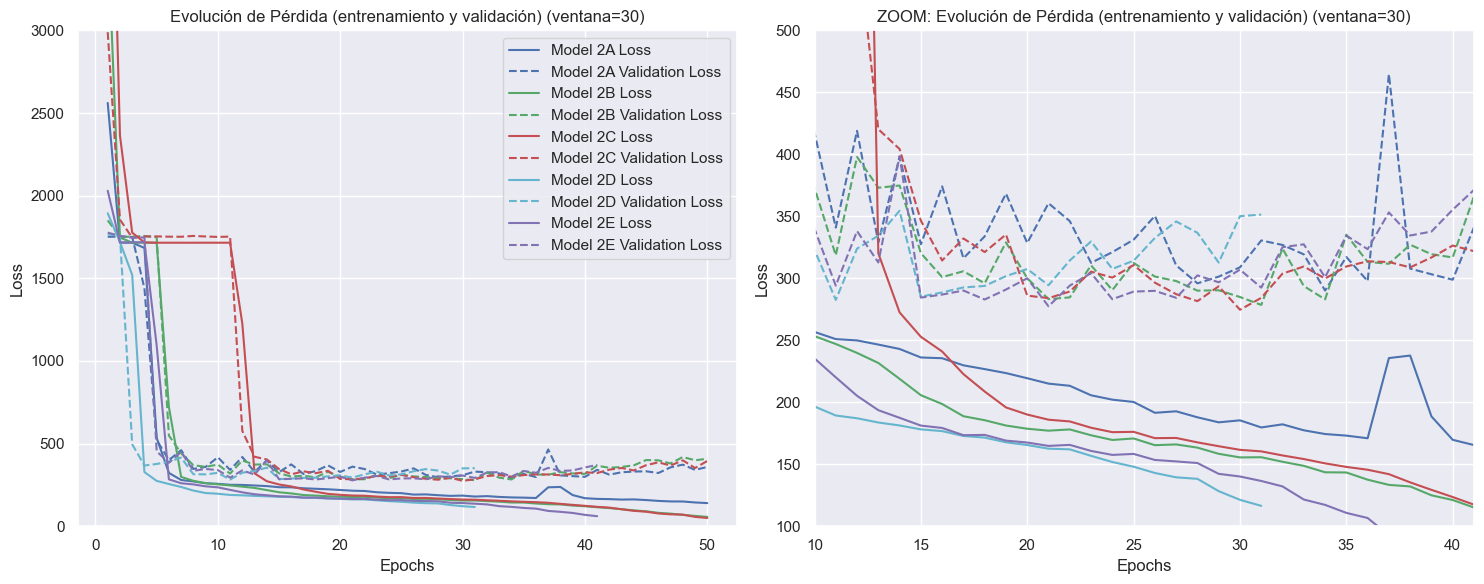

In [ ]:
models = ["2A", "2B", "2C", "2D", "2E"]
colors = ["b", "g", "r", "c", "m"]

#Gráfico de loss y val loss vs épocas. 
plt.figure(figsize=(15, 6))

for i, model in enumerate(models):
    loss = locals()[f"history_{model}"].history["loss"]
    val_loss = locals()[f"history_{model}"].history["val_loss"]
    color = colors[i]

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(loss) + 1), loss, color=color, label=f"Model {model} Loss")
    plt.plot(range(1, len(val_loss) + 1), val_loss, linestyle="dashed", color=color, label=f"Model {model} Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Evolución de Pérdida (entrenamiento y validación) (ventana=30)")
    plt.legend()
    plt.ylim(0, 3000)
    plt.grid(True)

    #Idem con zoom 
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(loss) + 1), loss, color=color, label=f"Model {model} Loss")
    plt.plot(range(1, len(val_loss) + 1), val_loss, linestyle="dashed", color=color, label=f"Model {model} Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("ZOOM: Evolución de Pérdida (entrenamiento y validación) (ventana=30)")
    plt.grid(True)
    plt.xlim(10, len(loss))
    plt.ylim(100, 500)

plt.tight_layout()
plt.show()

Al examinar la comparación de los cinco modelos utilizando una ventana más amplia (30), se destaca que, en todos los modelos, a diferencia de la ventana de tamaño 5, surge el fenómeno de sobreajuste a partir de alrededor de las 20 o 25 épocas. Esto es, se continúa disminuyendo el error en el conjunto de entrenamiento, pero el modelo ya no es capaz de generalizar, y por tanto aumenta el error en el conjunto de validación.

Es importante notar que los modelos A y B presentan resultados por encima (mayor error) en comparación con los modelos C, D y E, lo que lleva a considerar su descarte.

La siguiente gráfica analiza únicamente estos últimos 3 modelos:


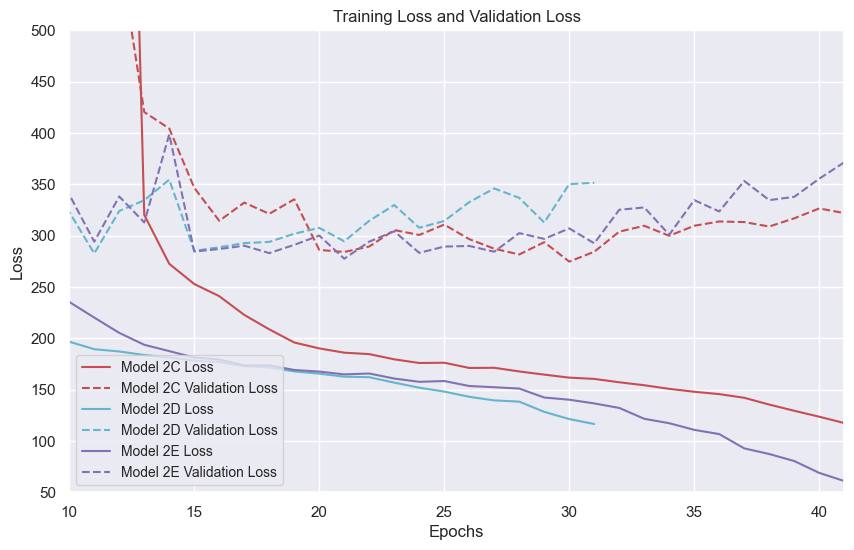

In [ ]:
models = [ "2C", "2D", "2E"]  
colors = ["r", "c", "m"]

plt.figure(figsize=(10, 6))
for i, model in enumerate(models):
    loss = locals()[f"history_{model}"].history["loss"]
    val_loss = locals()[f"history_{model}"].history["val_loss"]
    color = colors[i]  
    plt.plot(range(1, len(loss) + 1), loss, color=color, label=f"Model {model} Loss")
    plt.plot(range(1, len(val_loss) + 1), val_loss, linestyle="dashed", color=color, label=f"Model {model} Validation Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss and Validation Loss")

plt.xlim(10, len(loss))
plt.ylim(50, 500)
plt.legend(loc="lower left",fontsize="small")
plt.grid(True)
plt.show()


Al contrastar los modelos C, D y E, se aprecia que el modelo C requiere más tiempo para alcanzar la convergencia. A su vez, previo a la aparición de indicios de sobreajuste, es el modelo E el que consigue los resultados más prometedores, motivo por el cual se selecciona la arquitectura de dicho modelo.

**Gráfico 3: Comparación entre tamaños de ventana**

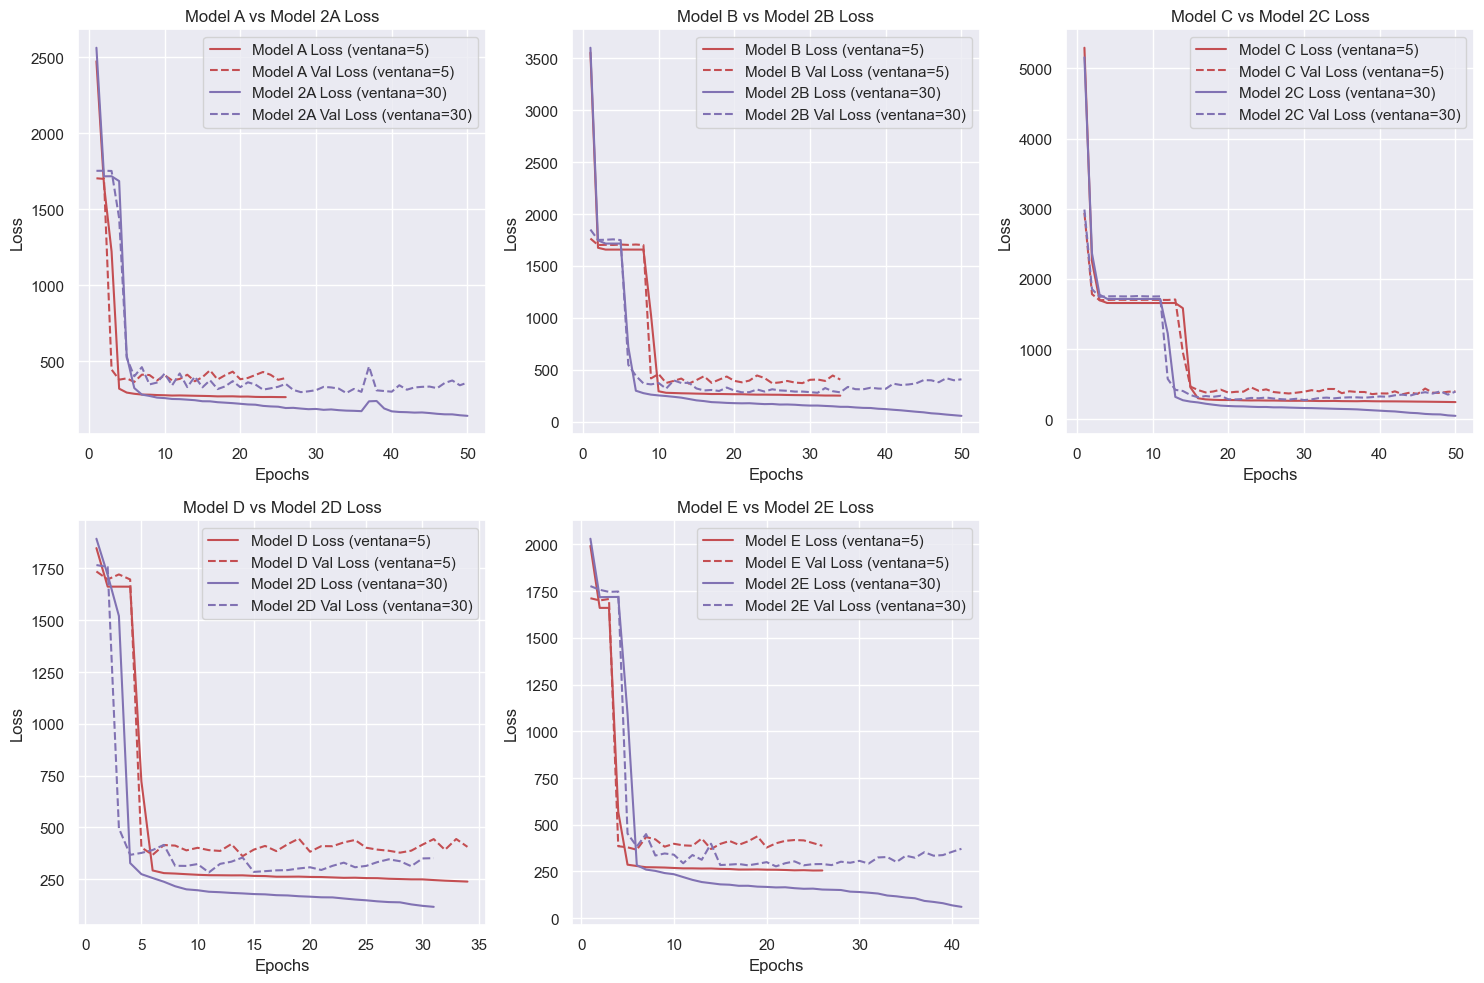

In [ ]:
models = ["A", "B", "C", "D", "E"]
colors = ["r", "m"]

plt.figure(figsize=(15, 10))

#Iterar sobre los modelos y graficar cada comparación
for i, model in enumerate(models):
    plt.subplot(2, 3, i+1)  #Núm.filas, núm. columnas, índice
    loss_A = locals()[f"history_{model}"].history["loss"]
    loss_2A = locals()[f"history_2{model}"].history["loss"]
    val_loss_A = locals()[f"history_{model}"].history["val_loss"]
    val_loss_2A = locals()[f"history_2{model}"].history["val_loss"]

    plt.plot(range(1, len(loss_A) + 1), loss_A, color=colors[0], label=f"Model {model} Loss (ventana=5)")
    plt.plot(range(1, len(val_loss_A) + 1), val_loss_A, linestyle="dashed",color=colors[0], label=f"Model {model} Val Loss (ventana=5)")
    plt.plot(range(1, len(loss_2A) + 1), loss_2A, color=colors[1], label=f"Model 2{model} Loss (ventana=30)")
    plt.plot(range(1, len(val_loss_2A) + 1), val_loss_2A, linestyle="dashed", color=colors[1], label=f"Model 2{model} Val Loss (ventana=30)")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Model {model} vs Model 2{model} Loss")
    plt.legend(loc="upper right")
    plt.grid(True)

plt.tight_layout()
plt.show()


Efectivamente, se puede observar que los cinco modelos logran un desempeño superior al emplear una ventana de tamaño 30. Esto resalta el claro impacto del tamaño de la ventana en el rendimiento general del modelo. 

### SELECCIÓN DE TAMAÑO DE VENTANA
En base a lo anterior, el siguiente paso se enfocó en evaluar minuciosamente el modelo seleccionado (Modelo E) al variar el tamaño de la ventana en incrementos de 5, comprendiendo desde 5 hasta 30. Esta evaluación se realizará utilizando validación cruzada e implementando técnicas como "Early Stopping" y "ModelCheckpoint" para detener el entrenamiento antes de que se presente el sobreajuste y para almacenar los mejores resultados obtenidos en cada iteración.

In [8]:
#Semilla
seed=42
tf.keras.utils.set_random_seed(seed)
tf.config.experimental.enable_op_determinism()

#Definir rango de ventanas a evaluar. 
ventana=range(30,0,-5)

#Definir columnas para crear secuencias, cantidad de features y batch
col_x=list(set(X_train.columns)-set(["unit_num"]))
col_y=["RUL"]
num_features=len(col_x)
batch=64

#Lista para guardar resultados.
resultados=[]

for v in ventana:

    #Crear la instancia de GroupShuffleSplit
    gss = GroupShuffleSplit(n_splits=5, test_size=0.15, random_state=seed)
    rmse_scores=[]
    
    #Iterar sobre los splits de validación cruzada
    for train_inices, val_indices in gss.split(X_train, y_train, groups):
        
        #Conjuntos de entrenamiento y validación
        X_train_split, X_val_split = X_train.iloc[train_inices], X_train.iloc[val_indices]
        X_train_array=Crear_Secuencias_X_total(X_train_split,v,col_x)
        X_val_array=Crear_Secuencias_X_total(X_val_split,v,col_x)

        y_train_split, y_val_split = y_train.iloc[train_inices], y_train.iloc[val_indices]
        y_train_array=Crear_Secuencias_y_total(y_train_split,v,col_y)
        y_val_array=Crear_Secuencias_y_total(y_val_split,v,col_y)

        print(X_train_array.shape)

        #Crear y compilar el modelo
        inputs = Input(shape=(v, num_features))
        mask = Masking(mask_value=-99.)(inputs)
        lstm_1 = LSTM(256,return_sequences=True)(mask)
        lstm_2=LSTM(128,return_sequences=True)(lstm_1)
        lstm_3=LSTM(64,return_sequences=False)(lstm_2)
        Dense_1=Dense(64)(lstm_3)
        output = Dense(1)(Dense_1)

        model = Model(inputs=inputs, outputs=output)

        model.compile(loss="mean_squared_error", optimizer="adam")

        #Callbacks
        path_checkpoint = "model_checkpoint.h5"
        es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)

        modelckpt_callback = keras.callbacks.ModelCheckpoint(monitor="val_loss",
                                                             filepath=path_checkpoint,
                                                             verbose=1,
                                                             save_weights_only=True,
                                                             save_best_only=True,)

        #Entrenar el modelo:
        history = model.fit(X_train_array, y_train_array,
                            validation_data=(X_val_array, y_val_array),
                            epochs=25,
                            batch_size=batch,
                            callbacks=[es_callback, modelckpt_callback])

        #Cargar el mejor modelo guardado: 
        model.load_weights(path_checkpoint)

        #Predicción en el conjunto de validación
        y_val_pred = model.predict(X_val_array)
        mse = mean_squared_error(y_val_array, y_val_pred)
        rmse = np.sqrt(mse)
        rmse_scores.append(rmse)

    resultados.append((v, rmse_scores))

(46317, 30, 22)
Epoch 1/25
721/724 [============================>.] - ETA: 0s - loss: 2023.2322
Epoch 1: val_loss improved from inf to 1776.12463, saving model to model_checkpoint.h5
724/724 [==============================] - 36s 26ms/step - loss: 2022.7308 - val_loss: 1776.1246
Epoch 2/25
724/724 [==============================] - ETA: 0s - loss: 1717.3672
Epoch 2: val_loss improved from 1776.12463 to 1756.88354, saving model to model_checkpoint.h5
724/724 [==============================] - 16s 22ms/step - loss: 1717.3672 - val_loss: 1756.8835
Epoch 3/25
723/724 [============================>.] - ETA: 0s - loss: 1526.1661
Epoch 3: val_loss improved from 1756.88354 to 487.93314, saving model to model_checkpoint.h5
724/724 [==============================] - 15s 21ms/step - loss: 1525.1743 - val_loss: 487.9331
Epoch 4/25
724/724 [==============================] - ETA: 0s - loss: 327.8764
Epoch 4: val_loss improved from 487.93314 to 380.41849, saving model to model_checkpoint.h5
724/724 [

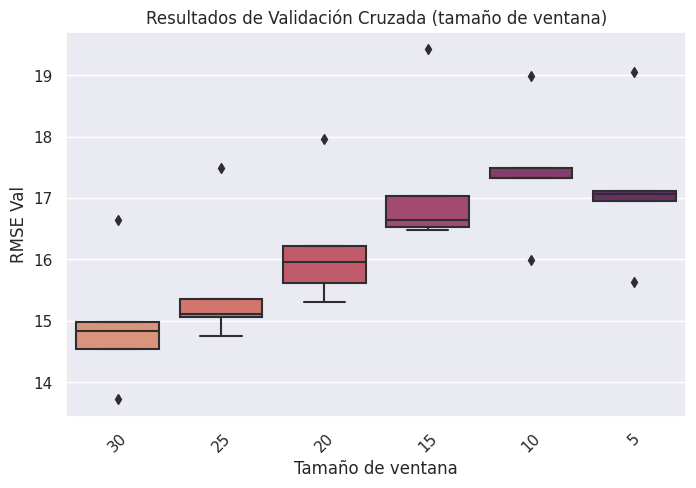

In [9]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=[resultado[1] for resultado in resultados], palette="flare")
plt.xticks(range(len(resultados)), [resultado[0] for resultado in resultados], rotation=45)
plt.xlabel("Tamaño de ventana")
plt.ylabel("RMSE Val")
plt.title("Resultados de Validación Cruzada (tamaño de ventana)")
plt.show()

In [11]:
data = {"Tamaño de Ventana": [], "Promedio RMSE": []}

for window_size, rmse_list in resultados:
    data["Tamaño de Ventana"].append(window_size)
    data["Promedio RMSE"].append(sum(rmse_list) / len(rmse_list))

df = pd.DataFrame(data)
print(df)

   Tamaño de Ventana  Promedio RMSE
0                 30      14.941982
1                 25      15.549918
2                 20      16.210686
3                 15      17.223029
4                 10      17.423670
5                  5      17.161842


Si bien al pasar de una ventana de 5 a 10 el error aumentó, al continuar incrementando el tamaño de ésta, el error disminuye de manera significativa. Esto lleva a la elección del tamaño de ventana 30, que demostró tener el menor error entre las opciones evaluadas.

In [1]:
from IPython.core.display import HTML, display

style = """
<style>
div.output_area {
    max-height: 500px; 
}

.rendered_html p {
    text-align: justify;
    font-size: 13px;
}

.rendered_html ul li, .rendered_html ol li {
    font-size: 13px;
}

.rendered_html h2#eda {
    background-color: #80B8D1;
    color: white;
    padding: 10px;
    font-size: 18px;
}
</style>
"""

display(HTML(style))